![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

# стандартные библиотеки
import re
import json
from ast import literal_eval
from collections import Counter

# библиотеки для работы с данными
import numpy as np
import pandas as pd

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set()
%matplotlib inline

# методы для подготовки к обучению и обучения модели
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import os
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

Загружаем необходимые файлы. У нас есть датасет для обучения модели ```main_task.csv``` и датасет, на котором будет проводиться тестирование нашей модели, ```kaggle_task.csv```. Также нам понадобится файл ```sample_submission.csv```, который нам будет необходимо заполнить, чтобы участвовать в соревновании на kaggle.

Также воспользуемся дополнительным файлом, ```word_evals.json```, который поможет нам определить настроение отзыва, негативное или позитивное.

In [4]:
DATA_INIT_PATH = "./"
DATA_DIR = DATA_INIT_PATH+ "data/"
df_train = pd.read_csv(DATA_DIR+"main_task.csv")
df_test = pd.read_csv(DATA_DIR+"kaggle_task.csv")
sample_submission = pd.read_csv(DATA_DIR+"sample_submission.csv")

# загружаем датасет, содержащий слова со значениями, от -5 (негативное слово) до +5 (позитивное)
# скачано с http://www2.imm.dtu.dk/pubdb/pubs/6010-full.html и переведено в формат json
with open(DATA_INIT_PATH+"word-evals/word_evals.json") as f:
    word_evals = json.loads(f.read())

Посмотрим, что из себя представляют наши датасеты

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
list(word_evals.items())[:10]

[('abandon', -2),
 ('abandoned', -2),
 ('abandons', -2),
 ('abducted', -2),
 ('abduction', -2),
 ('abductions', -2),
 ('abhor', -3),
 ('abhorred', -3),
 ('abhorrent', -3),
 ('abhors', -3)]

In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train["sample"] = 1  # помечаем где у нас трейн
df_test["sample"] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, поэтому просто заполняем нулями
df_test["Rating"] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

# т.к. мы будем изменять объединенный датасет, создадим маску для более простого доступа к трейну
is_train = data["sample"] == 1

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на "www.tripadvisor.com" 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
24818,id_116,Amsterdam,"['Mediterranean', 'Italian', 'European', 'Vege...",117.0,$$ - $$$,1307.0,"[['Real Italian food', 'Super lunch in Amsterd...",/Restaurant_Review-g188590-d4548131-Reviews-IL...,d4548131,1,4.5
43745,id_1239,Krakow,NaN,1242.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274772-d12188784-Reviews-O...,d12188784,1,1.0
21445,id_9657,Paris,['Thai'],9659.0,$$ - $$$,48.0,"[['Great Thai food near the Eiffel Tower', 'ki...",/Restaurant_Review-g187147-d3862697-Reviews-Ki...,d3862697,1,4.0
43268,id_509,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",510.0,$$ - $$$,250.0,"[['Tasty food vege and vegan', 'Very Tasty'], ...",/Restaurant_Review-g188590-d1382299-Reviews-De...,d1382299,1,4.0
36260,id_280,Prague,"['Italian', 'Mediterranean', 'European', 'Vege...",281.0,$$ - $$$,388.0,[['Nice place to eat a pizza and listen to go....,/Restaurant_Review-g274707-d7156030-Reviews-Ri...,d7156030,1,4.5


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## Фунции, используемые в предобработке

In [15]:
def string_to_list(string):
    """Принимает список, представленный в виде строки и возвращает реальный список (объект с типом list)"""

    if type(string) != str or not string.startswith("[") and not string.endswith("]"):
        return []
    string = string.replace("nan", '""')

    return literal_eval(string)

In [16]:
def get_dummies_from_lists(col, prefix):
    """
    Кодирует колонку, значения которой являются списками, с помощью объекта
    MultiLabelBinarizer библиотеки sklearn

    :param col: колонка, значения которой являются списками
    :param prefix: префикс, добавляемый перед каждой колонкой новых признаков
    :returns датафрейм, содержащий dummy значения
    """

    mlb = MultiLabelBinarizer()
    dummy_values = mlb.fit_transform(col)
    columns = prefix + "_" + mlb.classes_

    return pd.DataFrame(dummy_values, columns=columns).astype(np.uint8)

In [17]:
def extract_dates_from_reviews(reviews_series):
    """Извлекает даты из столбца Reviews"""

    def get_date(reviews, i):
        return reviews[1][i] if len(reviews[1]) > i else None

    date1 = reviews_series.apply(lambda x: get_date(x, 0)).astype(np.datetime64)
    date2 = reviews_series.apply(lambda x: get_date(x, 1)).astype(np.datetime64)

    return date1, date2

In [18]:
def get_text_from_reviews(df):
    """Извлекает текст из отзывов и возвращает его в виде строки"""

    reviews_text = df["Reviews"].apply(lambda reviews: " ".join(reviews[0]))
    return " ".join([review.lower() for review in reviews_text.values])

In [19]:
def show_wordcloud(text):
    """Показывает облако слов, используя предоставленный текст"""

    wordcloud = WordCloud(max_words=50, min_font_size=8,
                          background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [20]:
def get_num_of_cuisine_styles_by_city(df):
    """Считает количество видов кухни по городам"""

    group_by_city = df.explode("Cuisine Style").groupby("City")[
        "Cuisine Style"]

    return group_by_city.aggregate(lambda x: len(set(x.values))).sort_values(ascending=False)

In [21]:
def get_lowercase_words(s):
    """Функция оставляет только буквы и переводит их в строчные"""
    
    return [m[0].lower() for w in s.split(" ") for m in [re.findall(r"(\w+)", w)] if m]

In [22]:
def get_value_of_words(words):
    """Определяет общее настроение слов, меньше нуля - негативное, больше - позитивное"""
    
    return sum([val for w in words for val in [word_evals.get(w)] if val is not None])

In [23]:
def normalize(col):
    """Нормализует значение признака так, чтобы его значения были от -1 до 1"""
    
    center = col - col.mean()
    norm = np.sqrt((col ** 2).sum())
    return center / norm

## Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [24]:
# для примера я возьму столбец Number of Reviews
data["Number_of_Reviews_isNAN"] = pd.isna(data["Number of Reviews"]).astype("uint8")

In [25]:
# далее заполняем пропуски 0
data["Number of Reviews"].fillna(0, inplace=True)

In [26]:
data["Cuisine Style"][0]

"['Bar', 'Pub']"

In [27]:
# заполним пропуски в столбце Cuisine Style информацией, что вид кухни неизвестен
# не будем делать отдельную колонку о наличии пропуска, т.к. если вид кухни неизвестен,
# следовательно там был пропуск
data["Cuisine Style"].fillna('["Unknown"]', inplace=True)

In [28]:
# так выглядит пустое значение отзывов
data["Reviews"][0]

'[[], []]'

In [29]:
# также сделаем столбец, обозначающий наличие пропусков в Reviews,
# и заменим пропуски пустым двумерным массивом
data["Reviews_isNAN"] = pd.isna(data["Reviews"]).astype("uint8")
data["Reviews"].fillna("[[], []]", inplace=True)

In [30]:
# заполним пропуски в столбце Price Range самым часто встречаюшимся значением
data["Price_Range_isNAN"] = pd.isna(data["Price Range"]).astype("uint8")
data["Price Range"].fillna(data["Price Range"].mode()[0], inplace=True)

In [31]:
# столбцы Cuisine Style и Reviews содержат списки, представленные в виде строк
# заменим эти значения на настоящие списки
data["Cuisine Style"] = data["Cuisine Style"].apply(string_to_list)
data["Reviews"] = data["Reviews"].apply(string_to_list)

## Обработка признаков

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na


In [32]:
# исправим ошибку в названии города
data["City"].replace({"Oporto": "Porto"}, inplace=True)

# оставим признак City, т.к. в будущем он нам понадобится
data_dummies = pd.get_dummies(data, columns=["City"])
data = pd.concat([data["City"], data_dummies], axis=1)

#### Возьмем следующий признак "Price Range".

In [33]:
data["Price Range"].value_counts()

$$ - $$$    40402
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию "Price Range" это - Цены в ресторане.  
Т.к. это ранговый признак, для его кодирования применим Label Encoding

In [34]:
data["Price Range"].replace({"$": 0, "$$ - $$$": 1, "$$$$": 2}, inplace=True)

> Для некоторых алгоритмов МЛ даже для не категориальных признаков можно применить One-Hot Encoding, и это может улучшить качество модели. Пробуйте разные подходы к кодированию признака - никто не знает заранее, что может взлететь.

In [35]:
# кодируем признак Cuisine Style в dummy значения
dummies = get_dummies_from_lists(data["Cuisine Style"], "Cuisine")
data = pd.concat([data, dummies], axis=1)

# EDA  и Feature Engineering
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение целевой переменной

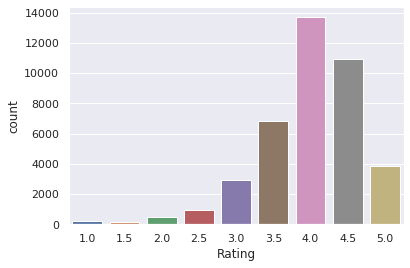

In [36]:
sns.countplot("Rating", data=data[is_train])
plt.show()

### Занимаемое место в городе

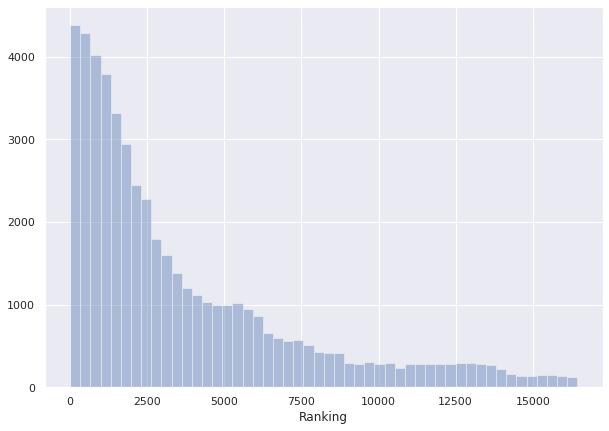

In [37]:
plt.rcParams["figure.figsize"] = (10, 7)
sns.distplot(data["Ranking"], kde=False)
plt.show()

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

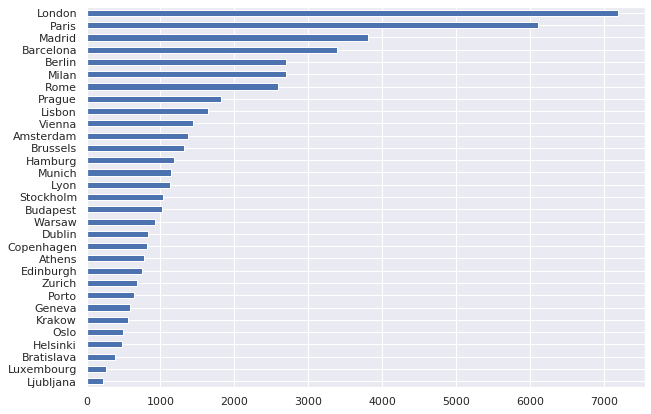

In [38]:
data["City"].value_counts(ascending=True).plot(kind="barh")
plt.show()

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

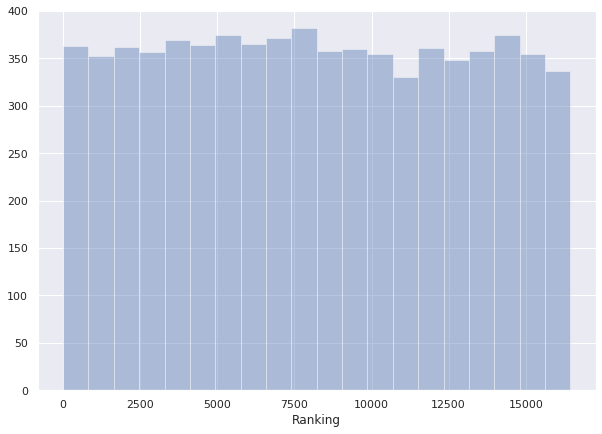

In [39]:
# распределение по Лондону
sns.distplot(data["Ranking"][data["City"] == "London"], kde=False)
plt.show()

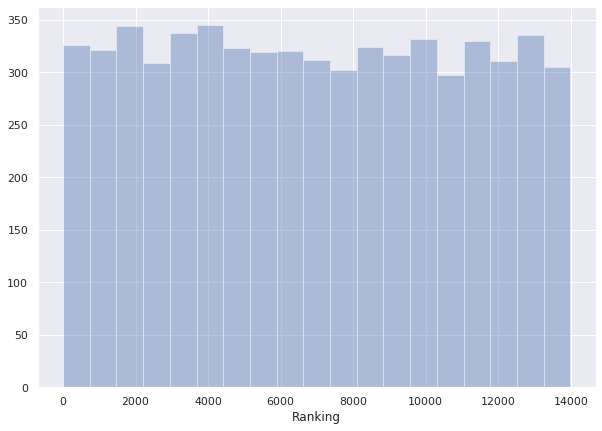

In [40]:
# распределение по Парижу
sns.distplot(data["Ranking"][data["City"] == "Paris"], kde=False)
plt.show()

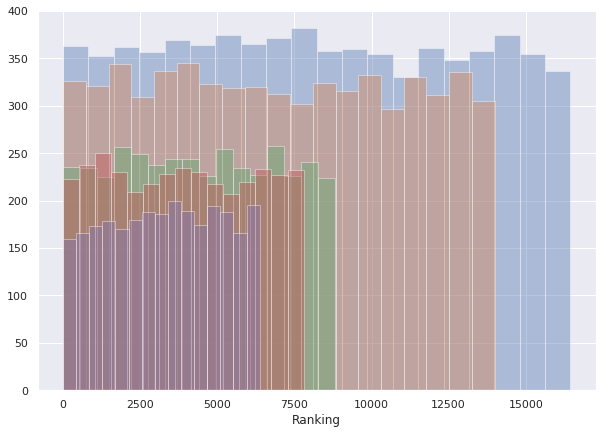

In [41]:
# посмотрим на топ 5 городов
for x in (data["City"].value_counts())[0:5].index:
    sns.distplot(data["Ranking"][data["City"] == x], kde=False)
plt.show()

Получается, что Ranking равномерно распределен, просто в больших городах больше ресторанов, из-за этого мы имеем смещение.
Создадим новый признак, нормализуя Ranking так, чтобы по каждому городу значение было от 0 до 1

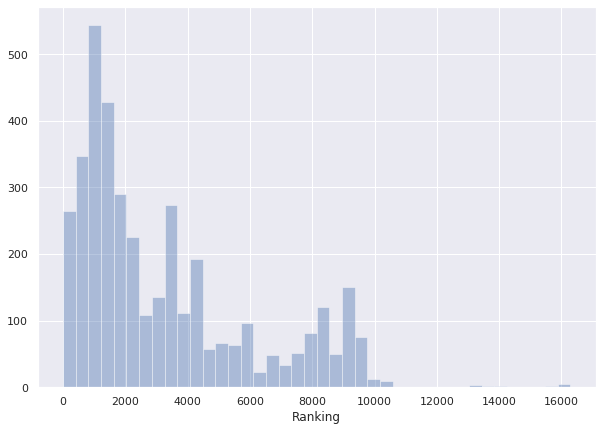

In [42]:
# распределение Ranking в случае наивысшего рейтинга
sns.distplot(data[data["Rating"] == 5]["Ranking"], kde=False)
plt.show()

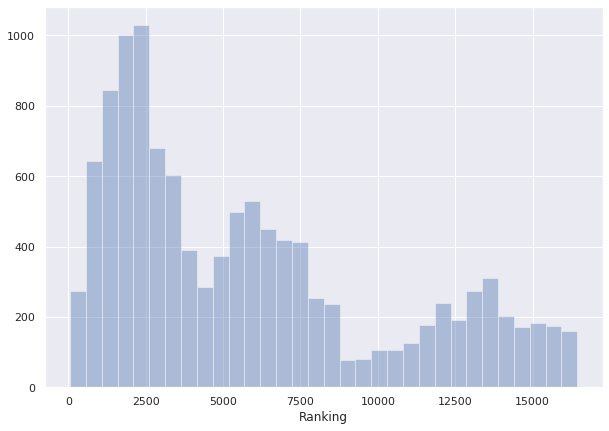

In [43]:
# распределение Ranking, в случае, когда рейтинг меньше 4
sns.distplot(data[(is_train) & (data["Rating"] < 4)]["Ranking"], kde=False)
plt.show()

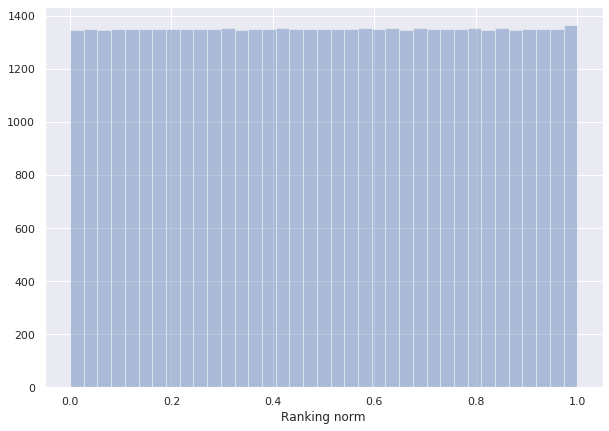

In [44]:
# нормализуем столбец Ranking в зависимости от города и добавим признак в датасет
data["Ranking norm"] = data.groupby("City")["Ranking"].rank(pct=True)
sns.distplot(data["Ranking norm"], kde=False)
plt.show()

### Количество отзывов

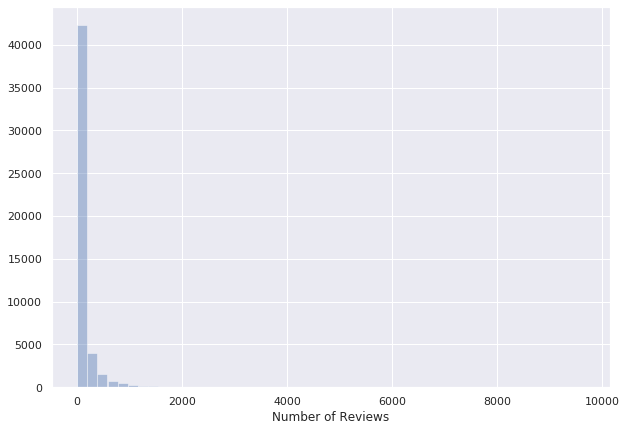

In [45]:
# посмотрим на распределение признака
sns.distplot(data["Number of Reviews"], kde=False)
plt.show()

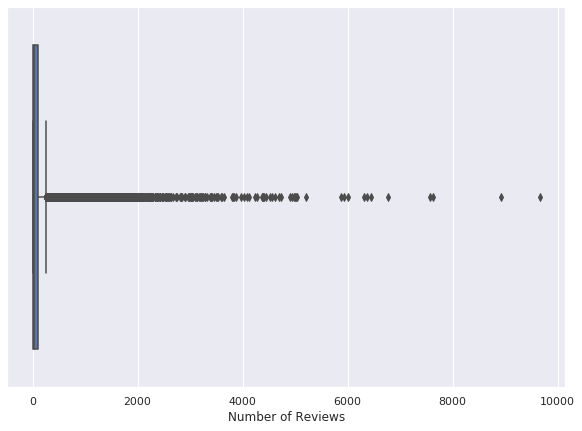

In [46]:
sns.boxplot(data["Number of Reviews"])
plt.show()

In [47]:
data["Number of Reviews"].describe()

count    50000.000000
mean       116.505040
std        286.173104
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

Как видим, признак распределен очень неравномерно и его распределение сильно смещено вправо

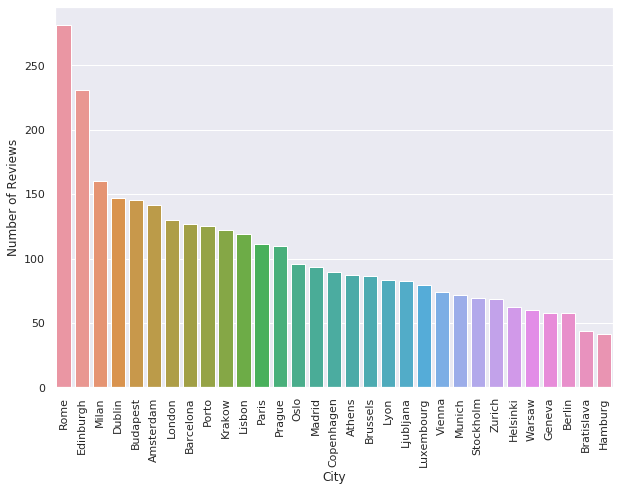

In [48]:
# посмотрим, какое среднее значение количества отзывов в зависимости от города
mean_num_of_reviews = data.groupby(
    "City")["Number of Reviews"].mean().sort_values(ascending=False)
ax = sns.barplot(mean_num_of_reviews.index, mean_num_of_reviews)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

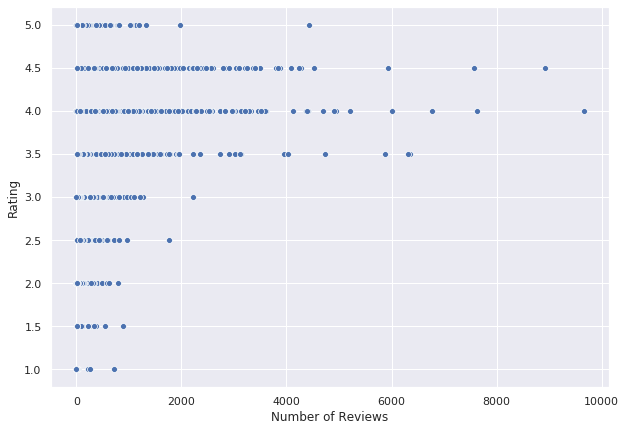

In [49]:
# диаграмма рассеивания количества отзывов и рейтинга
sns.scatterplot("Number of Reviews", "Rating", data=data[is_train])
plt.show()

In [50]:
# добавим признак, означающий среднее количество отзывов в городе нахождения ресторана
new_feature_name = "Number of Reviews (mean by city)"
data[new_feature_name] = data["City"].apply(lambda x: mean_num_of_reviews[x])

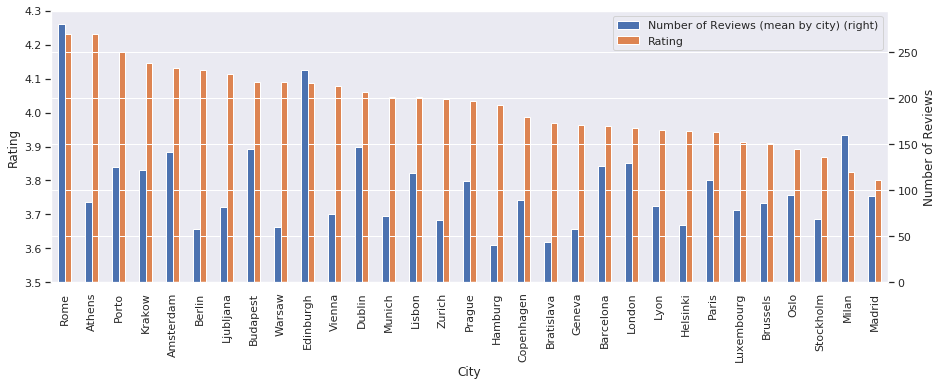

In [51]:
# теперь посмотрим на этот показатель в сравнении с рейтингом
df = data[is_train].groupby("City")[[new_feature_name, "Rating"]].mean()
df = df.sort_values(by="Rating", ascending=False)

ax = df.plot(kind="bar", secondary_y=new_feature_name, figsize=(15, 5))
ax.set_ylabel("Rating")
ax.set_ylim(3.5, 4.3)
ax.right_ax.set_ylabel("Number of Reviews")
plt.show()

Заметна небольшая положительная корреляция с рейтингом

### Отзывы

In [52]:
# извлечем даты из столбца Reviews
date1, date2 = extract_dates_from_reviews(data["Reviews"])

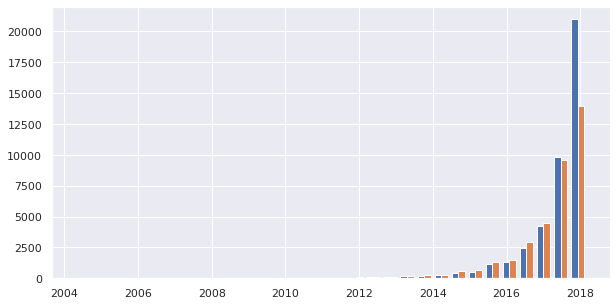

In [53]:
# посмотрим на распределение новых признаков
plt.rcParams["figure.figsize"] = (10, 5)
plt.hist([date1.dropna(), date2.dropna()], bins=30)
plt.show()

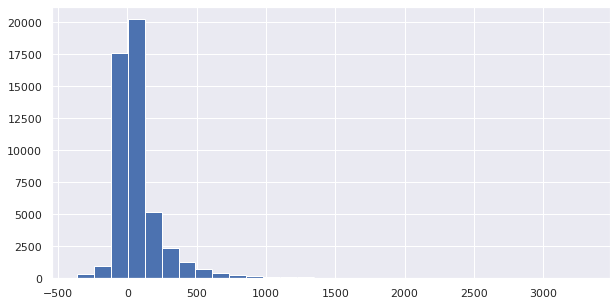

In [54]:
# добавим признак, обозначающий количество дней между двумя отзывами и признак, хранящий пропуски
data["Days Between Reviews"] = (date1 - date2).dt.days
data["Days_Between_Reviews_isNAN"] = data["Days Between Reviews"].isna().astype(np.uint8)
data["Days Between Reviews"].fillna(0, inplace=True)
data["Days Between Reviews"].hist(bins=30)
plt.show()

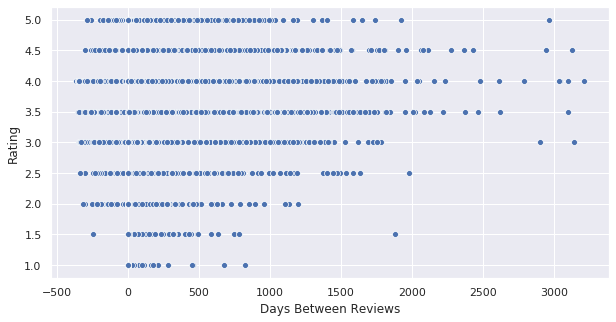

In [55]:
# диаграмма рессеивания нового признака с рейтингом
sns.scatterplot("Days Between Reviews", "Rating", data=data[is_train])
plt.show()

### Теперь посмотрим на текст отзывов

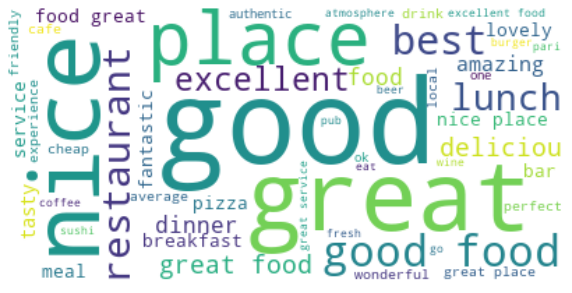

In [56]:
# посмотрим на часто встречающиеся слова у ресторанов с рейтигом от 3 и выше
plt.rcParams["figure.figsize"] = (10, 8)
show_wordcloud(get_text_from_reviews(data[data["Rating"] >= 3]))

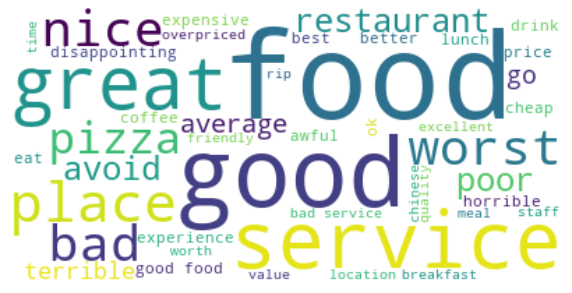

In [57]:
# и у ресторанов с рейтингом менее 3
show_wordcloud(get_text_from_reviews(data[(data["Rating"] < 3) & (is_train)]))

Заметно, что в последнем примере стали появляться более негативные слова, хотя раньше их не было видно.

In [58]:
reviews_text = get_text_from_reviews(data)
words = [word for word in reviews_text.split(" ") if re.match(r"\w{2,}", word)]
print(f"Всего отзывы содержат {len(set(words))} уникальных слов")

Всего отзывы содержат 22393 уникальных слов


В текстах отзывов содержится много уникальных слов, и я думаю нецелесообразно кодировать их значения с помощью One-Hot Encoding, будет получаться слишком много признаков. Поэтому мы попробуем получить какое-то одно число исходя из отзывов для каждого ресторана

Для этого будем использовать внешний датасет ```word_evals.json```, который представляет собой словарь, ключи которого - слова, а значения - значения слов в виде числа, обозначающего отношение от -5 (негативное) до +5 (позитивное)

In [59]:
# преобразуем отзывы в список слов
reviews_text_series = data["Reviews"].apply(lambda x: " ".join(x[0]))
words_series = reviews_text_series.apply(get_lowercase_words)
words_series.head(5)

0                                                   []
1    [very, good, reviews, fine, dining, in, hakani...
2               [better, than, the, links, ivy, black]
3         [most, exquisite, delicious, and, authentic]
4    [always, the, best, in, bratislava, very, good...
Name: Reviews, dtype: object

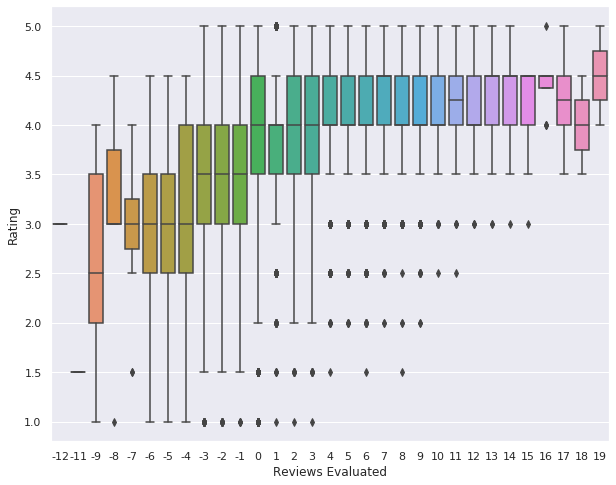

In [60]:
# добавляем новый признак, обозначающий отношение отзывов
data["Reviews Evaluated"] = words_series.apply(get_value_of_words)
sns.boxplot(data[is_train]["Reviews Evaluated"], data[is_train]["Rating"])
plt.show()

Мы видим распределение нового признака, заметно увеличение рейтинга при переходе от отрицательных значений признака к нулевому значению, а далее примерно одинаковые показатели

### Кухни

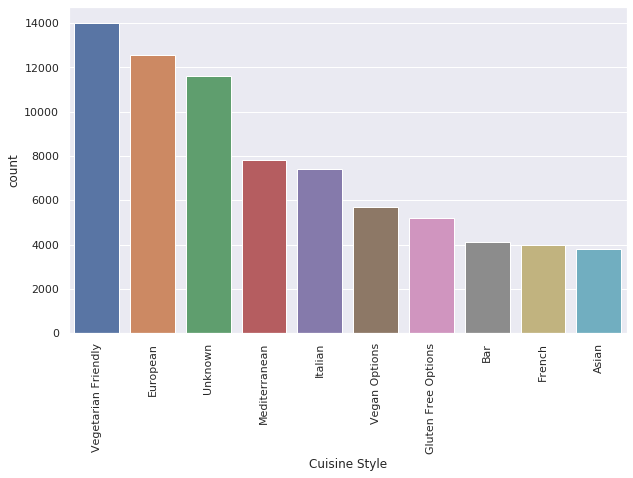

In [61]:
# посмотрим, какие виды кухонь самые популярные
plt.rcParams["figure.figsize"] = (10, 6)
cuisine_styles = data.explode("Cuisine Style")["Cuisine Style"]
top10_cuisines = cuisine_styles.value_counts()[:10]

ax = sns.countplot(cuisine_styles, order=top10_cuisines.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

Как мы видим, чаще всего встречаются вегетарианская и европейская кухня

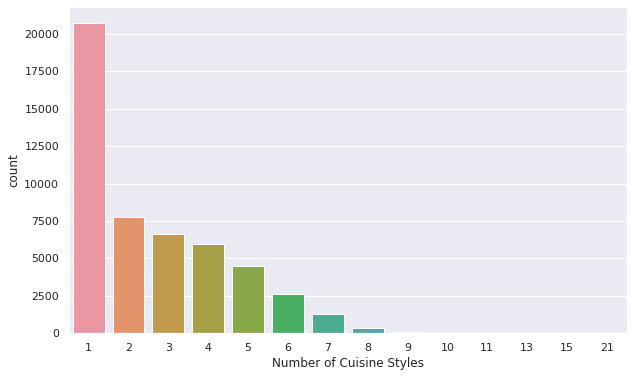

In [62]:
# также добавим новый признак, показывающий количество видов кухонь у ресторана и посмотрим на его распределение
data["Number of Cuisine Styles"] = data["Cuisine Style"].apply(len)
sns.countplot(data["Number of Cuisine Styles"])
plt.show()

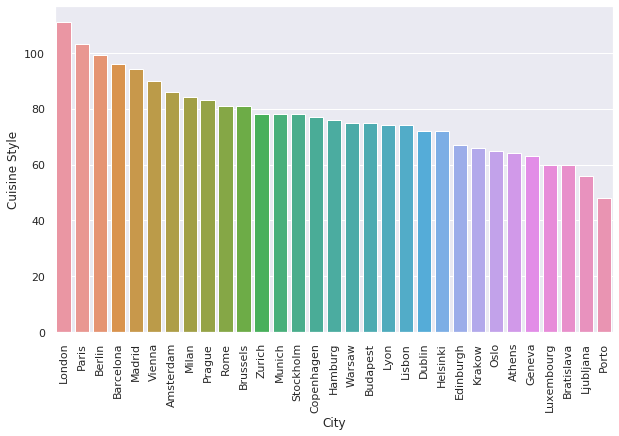

In [63]:
# посмотрим также на количество видов кухни по городам и добавим этот признак в датафрейм
num_cuisines_by_city = get_num_of_cuisine_styles_by_city(data)
data["Number of Cuisine Styles by City"] = data["City"].apply(
    lambda x: num_cuisines_by_city[x])

ax = sns.barplot(num_cuisines_by_city.index, num_cuisines_by_city)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

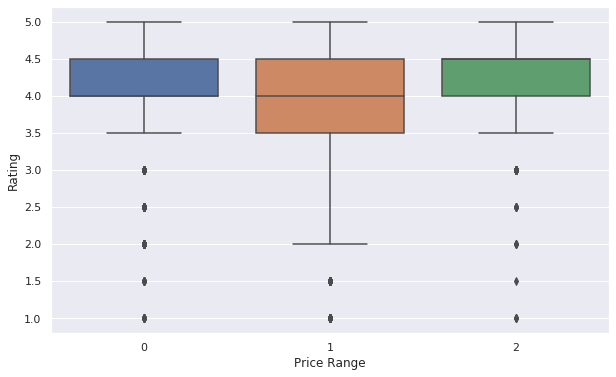

In [64]:
# распределение рейтинга относительно цен в ресторане
sns.boxplot("Price Range", "Rating", data=data[is_train])
plt.show()

Больше всего разброс рейтинга в средней ценовой категории, а распределения рейтинга для низкой и высокой ценовой категории похожи

#### Работа с признаками

In [65]:
#нормализуем числовые признаки, т.к. значения признаков находятся в разных диапазонах
data["Number of Reviews"] = normalize(data["Number of Reviews"])
data["Number of Reviews (mean by city)"] = normalize(data["Number of Reviews (mean by city)"])
data["Days Between Reviews"] = normalize(data["Days Between Reviews"])
data["Reviews Evaluated"] = normalize(data["Reviews Evaluated"])
data["Number of Cuisine Styles"] = normalize(data["Number of Cuisine Styles"])
data["Number of Cuisine Styles by City"] = normalize(data["Number of Cuisine Styles by City"])

### Корреляция признаков

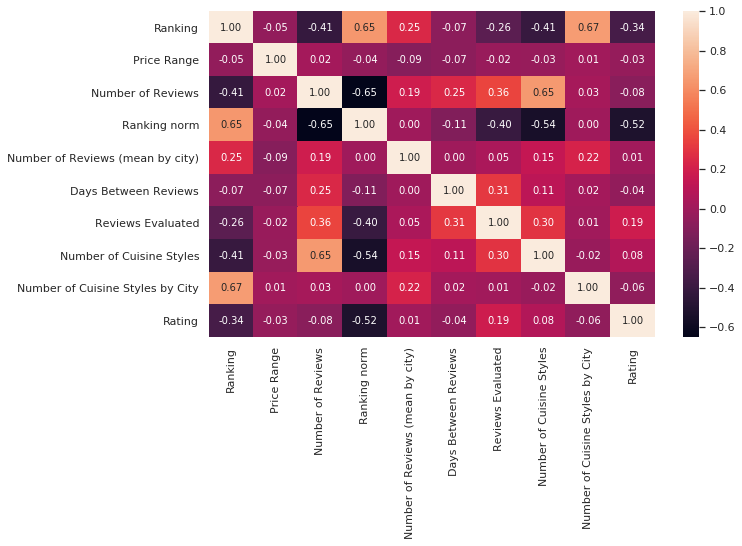

In [66]:
# для построения диаграммы корреляций используем только числовые и ранговые признаки
cols = ["City", "Ranking", "Price Range", "Number of Reviews", "Ranking norm",
        "Number of Reviews (mean by city)", "Days Between Reviews", 
        "Reviews Evaluated", "Number of Cuisine Styles", 
        "Number of Cuisine Styles by City", "Rating"]
corr = data.loc[is_train, cols].corr(method="spearman")

sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

In [67]:
# признаки, сортированные по наибольшей скоррелированности с рейтингом
np.abs(corr["Rating"].drop("Rating")).sort_values(ascending=False)

Ranking norm                        0.516185
Ranking                             0.341748
Reviews Evaluated                   0.186905
Number of Reviews                   0.076750
Number of Cuisine Styles            0.076335
Number of Cuisine Styles by City    0.056064
Days Between Reviews                0.044270
Price Range                         0.034555
Number of Reviews (mean by city)    0.009093
Name: Rating, dtype: float64

Наибольшая корреляция с рейтингом у признаков ```Ranking``` и ```Ranking norm```, практически никакой корреляции у признака ```Number of Reviews (mean by city)```. Я пробовал удалил его из датасета, но это только ухудшило прогноз модели. Поэтому его оставим, возможно есть какая-то нелинейная связь

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [85]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+"/main_task.csv")
df_test = pd.read_csv(DATA_DIR+"/kaggle_task.csv")
df_train["sample"] = 1
df_test["sample"] = 0
df_test["Rating"] = 0

data_model = df_test.append(df_train, sort=False).reset_index(drop=True)
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [86]:
def preproc_data(df_input):
    """Осуществляет предобработку данных для включением в модель"""

    df_output = df_input.copy()

    # ################### Работа с NAN ##############################################################
    df_output["Number_of_Reviews_isNAN"] = pd.isna(
        df_output["Number of Reviews"]).astype("uint8")
    df_output["Number of Reviews"].fillna(0, inplace=True)
    df_output["Cuisine Style"].fillna('["Unknown"]', inplace=True)
    df_output["Reviews_isNAN"] = pd.isna(df_output["Reviews"]).astype("uint8")
    df_output["Reviews"].fillna("[[], []]", inplace=True)
    df_output["Price_Range_isNAN"] = pd.isna(
        df_output["Price Range"]).astype("uint8")
    df_output["Price Range"].fillna(
        df_output["Price Range"].mode()[0], inplace=True)

    # ################### Предобработка ##############################################################

    # убираем не нужные для модели признаки
    df_output.drop(["Restaurant_id", "ID_TA", ], axis=1, inplace=True)

    # преобразуем колонки Cuisine Style и Reviews в список
    df_output["Cuisine Style"] = df_output["Cuisine Style"].apply(string_to_list)
    df_output["Reviews"] = df_output["Reviews"].apply(string_to_list)

    # ################### Encoding ##############################################################
    
    # переводим признаки Cuisine Style и City в dummy-значения
    df_output = pd.concat([df_output["City"], 
                           pd.get_dummies(df_output, columns=["City"])], axis=1)

    cuisine_dummies = get_dummies_from_lists(df_output["Cuisine Style"], "Cuisine")
    df_output = pd.concat([df_output, cuisine_dummies], axis=1)

    # заменяем значения Price Range на последовательные числа
    df_output["Price Range"].replace({"$": 0, "$$ - $$$": 1, "$$$$": 2}, 
                                     inplace=True)

    # ################### Feature Engineering ####################################################

    # добавим новый признак, обозначающий количество дней между двумя отзывами
    date1, date2 = extract_dates_from_reviews(df_output["Reviews"])
    days_between_reviews = (date1 - date2).dt.days
    days_between_reviews_is_nan = days_between_reviews.isna().astype(np.uint8)
    days_between_reviews = days_between_reviews.fillna(0)

    df_output["Days Between Reviews"] = days_between_reviews
    df_output["Days_Between_Reviews_isNAN"] = days_between_reviews_is_nan

    # нормализуем столбец Ranking в зависимости от города
    df_output["Ranking norm"] = df_output.groupby("City")["Ranking"].rank(pct=True)

    # добавим новый признак, обозначающий среднее количество отзывов в зависимости от города
    reviews_by_city = df_output.groupby("City")["Number of Reviews"].mean()
    df_output["Number of Reviews (mean by city)"] = df_output["City"].apply(
        lambda x: reviews_by_city[x])
    
    # добавим признак, обозначающий количество видов кухни у ресторана
    df_output["Number of Cuisine Styles"] = df_output["Cuisine Style"].apply(len)

    # и признак, обозначающий количество видов кухни по городам
    num_cuisines_by_city = get_num_of_cuisine_styles_by_city(df_output)
    df_output["Number of Cuisine Styles by City"] = df_output["City"].apply(
        lambda x: num_cuisines_by_city[x])

    # также добавим признак, обозначающий общее настроение отзывов
    reviews_text_series = df_output["Reviews"].apply(lambda x: " ".join(x[0]))
    words_series = reviews_text_series.apply(get_lowercase_words)
    df_output["Reviews Evaluated"] = words_series.apply(get_value_of_words)
    
    # нормируем количественные признаки
    cols = ["Number of Reviews", "Number of Reviews (mean by city)", "Days Between Reviews",
           "Reviews Evaluated", "Number of Cuisine Styles", "Number of Cuisine Styles by City"]
    
    for col in cols:
        df_output[col] = normalize(df_output[col])

    # ################### Clean ####################################################
    # убираем не числовые признаки из датасета
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == "object"]
    df_output.drop(object_columns, axis=1, inplace=True)

    return df_output

#### Запускаем и проверяем что получилось

In [87]:
df_preproc = preproc_data(data_model)
df_preproc.sample(3)

,Ranking,Price Range,Number of Reviews,sample,Rating,Number_of_Reviews_isNAN,Reviews_isNAN,Price_Range_isNAN,City_Amsterdam,City_Athens,...,Cuisine_Wine Bar,Cuisine_Xinjiang,"Cuisine_Yun""""",Days Between Reviews,Days_Between_Reviews_isNAN,Ranking norm,Number of Reviews (mean by city),Number of Cuisine Styles,Number of Cuisine Styles by City,Reviews Evaluated
4030,5169.0,0,-0.001411,0,0.0,0,0,0,0,0,...,0,0,0,-0.000344,0,0.378684,-0.000177,0.003322,0.000717,0.003050
1761,2966.0,1,-0.001599,0,0.0,0,0,1,0,0,...,0,0,0,-0.001796,1,0.479213,0.001534,-0.002274,-0.000229,-0.003088
28034,325.0,2,-0.001165,1,4.5,0,0,0,0,0,...,1,0,0,-0.002949,0,0.119005,-0.001163,0.000524,-0.000726,-0.001042


In [88]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 172 entries, Ranking to Reviews Evaluated
dtypes: float64(9), int64(2), uint8(161)
memory usage: 11.9 MB


In [89]:
# теперь выделим тестовую часть
train_data = df_preproc.query("sample == 1").drop(["sample"], axis=1)
test_data = df_preproc.query("sample == 0").drop(["sample"], axis=1)

y = train_data["Rating"].values
X = train_data.drop(["Rating"], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [90]:
# воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

In [91]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 171), (40000, 171), (40000, 170), (32000, 170), (8000, 170))

# Model 
Сам ML

In [92]:
# создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)
# округляем результат, чтобы он был кратный 0.5, т.к. возможные значения рейтинга кратны 0.5
y_pred = np.round(y_pred*2) / 2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [93]:
# сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print("MAE:", metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1689375


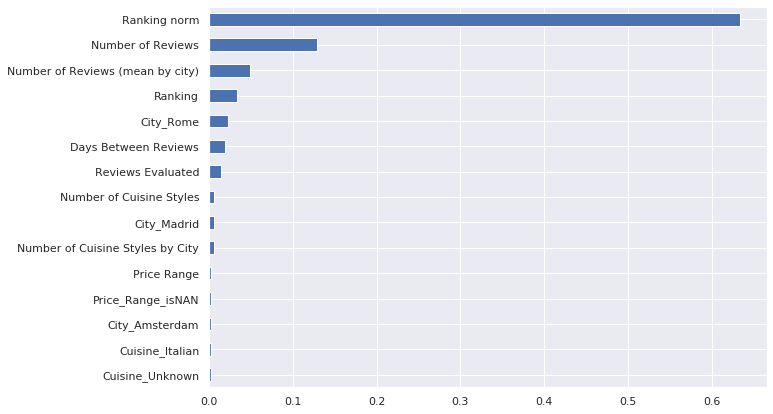

In [94]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams["figure.figsize"] = (10, 7)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15)[::-1].plot(kind="barh")
plt.show()

# Submission

In [95]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Number_of_Reviews_isNAN,Reviews_isNAN,Price_Range_isNAN,City_Amsterdam,City_Athens,City_Barcelona,...,Cuisine_Wine Bar,Cuisine_Xinjiang,"Cuisine_Yun""""",Days Between Reviews,Days_Between_Reviews_isNAN,Ranking norm,Number of Reviews (mean by city),Number of Cuisine Styles,Number of Cuisine Styles by City,Reviews Evaluated
9181,6009.0,0,-0.001368,0.0,0,0,0,0,0,0,...,0,0,0,-0.001796,1,0.686598,-0.000803,-0.002274,0.000269,-0.003088
598,1898.0,1,-0.001426,0.0,0,0,1,0,0,0,...,0,0,0,0.002976,0,0.276525,-0.002071,-0.002274,0.000518,0.003050
4321,796.0,1,0.000861,0.0,0,0,0,0,0,0,...,0,0,0,-0.001756,0,0.292576,-0.001567,0.001923,-0.000527,0.003050
3249,10984.0,1,-0.001657,0.0,0,0,1,0,0,0,...,0,0,0,-0.001796,1,0.785200,-0.000177,-0.002274,0.000717,-0.003088
2217,4203.0,1,-0.001686,0.0,1,0,1,0,0,0,...,0,0,0,-0.001796,1,0.482822,-0.000803,-0.002274,0.000269,-0.003088
3373,9098.0,1,-0.001657,0.0,0,0,1,0,0,0,...,0,0,0,-0.001796,1,0.655861,-0.000177,-0.002274,0.000717,-0.003088
6134,6031.0,1,-0.000890,0.0,0,0,0,0,0,0,...,0,0,0,-0.002432,0,0.439915,-0.000177,0.003322,0.000717,0.002027
5952,10477.0,1,-0.001643,0.0,0,0,0,0,0,0,...,0,0,0,0.025009,0,0.647296,0.000468,-0.002274,0.001115,-0.002065
4105,665.0,1,-0.000268,0.0,0,0,0,0,0,0,...,0,0,0,-0.007304,0,0.323243,-0.001983,-0.000875,-0.000676,-0.003088
7645,137.0,1,0.005782,0.0,0,0,0,0,0,0,...,0,0,0,-0.001796,0,0.135246,-0.000739,0.004721,-0.001174,-0.003088


In [96]:
test_data = test_data.drop(["Rating"], axis=1)

In [97]:
sample_submission

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
...,...,...
9995,id_9995,4.5
9996,id_9996,4.0
9997,id_9997,3.0
9998,id_9998,4.5


In [98]:
prediction = model.predict(test_data)
predict_submission = np.round(prediction*2) / 2

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [99]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4. ])

In [100]:
sample_submission["Rating"] = predict_submission
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5
